# **Traffic Predictions**
#### (by David Smolinski)
___
<br>

### **Skills this adds to my portfolio:**
- machine learning (linear regression)
- seaborn
- timestamp, datetime, time series
___
<br>

### **Summary:**
This program predicts the traffic rate for a road (Interstate 94 Westbound) at a location (DoT ATR station 301, Minnesota) based on temperature and cloudiness. The main goal was to have linear regression in my portfolio. Using this model is not much better than gessing the mean traffic because the standard deviation is not much greater than the RMSE (1987 vs 1964 entities/h).
<br><br>

Important variables and their units (See the dataset source page for more details.):

Features (used to make predictions):
- temp: temperature in degrees Kelvin
- clouds_all: % cloud coverage

Response (what we are trying to predict):
- traffic_volume: the traffic rate in entities/h
___
<br>

### **Links:**
- [my portfolio](https://github.com/DavidSmolinski/portfolio/tree/master/table%20of%20contents)
- [dataset source (UC Irvine Machine Learning Repository)](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)
- [the csv](https://archive.ics.uci.edu/ml/machine-learning-databases/00492/)
- [Linkedin](https://www.linkedin.com/in/davidsmolinski)

In [3]:
%matplotlib inline
import requests, gzip, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
url = (r"https://archive.ics.uci.edu/ml/machine-learning-databases/00492/"
       r"Metro_Interstate_Traffic_Volume.csv.gz")
response = requests.get(url)
csv_gz_file = response.content
f = BytesIO(csv_gz_file)
with gzip.GzipFile(fileobj=f) as csv:
    df = pd.read_csv(csv, delimiter=',')

In [5]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
pd.set_option('display.max_columns', None)
print(f'df shape: {df.shape}')
df.head(1)

df shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545


If we plotted all elements, the scatter plots would be crowded, and we wouldn't be able to see separate dots. I plotted average values for each month (12 dots/plot).

The dataset covers this amount of time: 2189 days 14:00:00



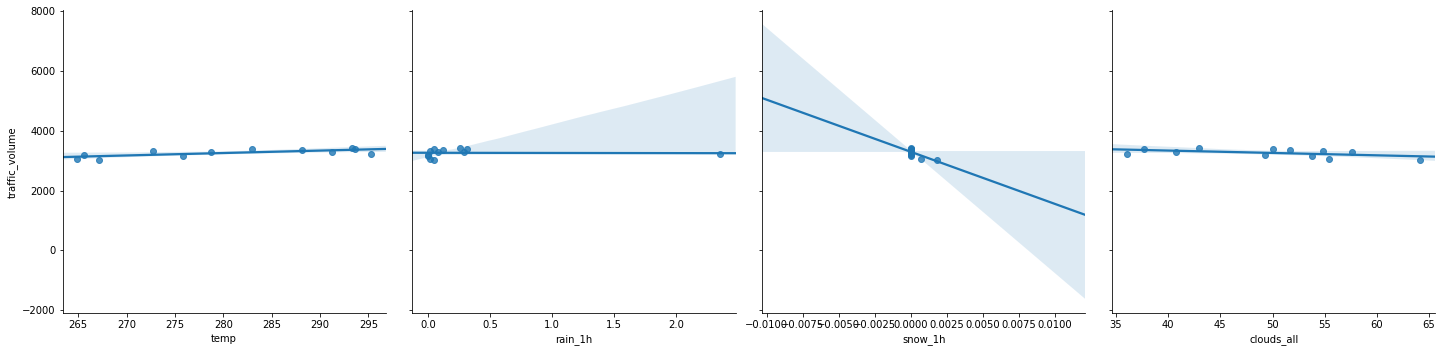

In [8]:
df['date_time'] = pd.to_datetime(df.date_time)
print(f'The dataset covers this amount of time: '
      f'{df.date_time.max()-df.date_time.min()}\n')

# Scatter plots with 48204 dots would be hard to read.
# I made a new dataframe with 1 row for each month and plotted that.
df['month'] = df.date_time.dt.month
month_averages_df = df.groupby('month').mean()
potential_features = ['temp',  'rain_1h',  'snow_1h',  'clouds_all']
sns.pairplot(month_averages_df, x_vars=potential_features,
             y_vars='traffic_volume', height=5, aspect=1., kind='reg')

We want features with a linear relationship to "traffic_volume" ("temp" and "clouds_all").

In [9]:
correlations_to_traffic_volume = [
    (x, abs(df['traffic_volume'].corr(df[x]))) for x in potential_features]
print(f'Absolute correlations of features to the target'
      f'(higher is better): {correlations_to_traffic_volume}')

Absolute correlations of features to the target(higher is better): [('temp', 0.13029879817112666), ('rain_1h', 0.004713702367859206), ('snow_1h', 0.0007334345358283909), ('clouds_all', 0.06705377704283508)]


"temp" and "clouds_all" also have > 10 times better correlation to "traffic_volume" than the other features. I am choosing them as features.

In [10]:
linreg = LinearRegression()
feature_cols = ['temp', 'clouds_all']
x = df[feature_cols]
target_col = 'traffic_volume'
y = df[target_col]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=4)

In [11]:
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print('Error (E):')
print(f'MAE (mean abs. E): {metrics.mean_absolute_error(y_test,y_pred):.0f}')
print(f'MSE (mean squared E): {metrics.mean_squared_error(y_test,y_pred):.0f}')
print(f'RMSE (root MSE): '
      f'{np.sqrt(metrics.mean_squared_error(y_test,y_pred)):.0f}')

Error (E):
MAE (mean abs. E): 1714
MSE (mean squared E): 3857773
RMSE (root MSE): 1964


In [12]:
linreg.fit(x, y)
y_intercept = linreg.intercept_
feature_coefs = linreg.coef_
print(f'prediction equation: {target_col} = '
      f'{feature_coefs[0]:.3f}({feature_cols[0]}) + '
      f'{feature_coefs[1]:.3f}({feature_cols[1]}) + {y_intercept:.3f}')

prediction equation: traffic_volume = 20.643(temp) + 4.134(clouds_all) + -2749.061


In [13]:
# I'm making up a fake situation where there is lots of traffic because it is
# hot and not cloudy.
temp_k = 305
percent_cloudy = 0
situation = [temp_k, percent_cloudy]
print(f'predicted traffic when it is {temp_k} Kelvin and {percent_cloudy}% '
      f'cloudy:\n{linreg.predict([situation])[0]:.0f} entities/h')

predicted traffic when it is 305 Kelvin and 0% cloudy:
3547 entities/h
